In [ ]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy import signal
from scipy.signal import butter, sosfilt, sosfreqz
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Motor Imagery dataset load

mat = scipy.io.loadmat('drive/MyDrive/MI_cnt_train.mat')
tr_cnt_ = np.array(mat.get('cnt1'))

mat_Y = scipy.io.loadmat('drive/MyDrive/MI_cnt_train_label.mat')
tr_Label = np.array(mat_Y.get('label'))

mat_m = scipy.io.loadmat('drive/MyDrive/MI_cnt_train_marker.mat')
tr_marker = np.array(mat_m.get('marker'))

mat = scipy.io.loadmat('drive/MyDrive/MI_cnt_test.mat')
te_cnt_ = np.array(mat.get('cnt1'))

mat_Y = scipy.io.loadmat('drive/MyDrive/MI_cnt_test_label.mat')
te_Label = np.array(mat_Y.get('label'))

mat_m = scipy.io.loadmat('drive/MyDrive/MI_cnt_test_marker.mat')
te_marker = np.array(mat_m.get('marker'))

In [ ]:
CH = ['Fp1','Fp2','F7','F3','Fz','F4','F8','FC5','FC1','FC2','FC6', 
      'T7','C3','Cz','C4','T8','TP9','CP5','CP1','CP2','CP6','TP10',
      'P7','P3','Pz','P4','P8','PO9''O1','Oz','O2','PO10','FC3','FC4',
      'C5','C1','C2','C6','CP3','CPz','CP4','P1','P2','POz','FT9','FTT9h',
      'TTP7h','TP7','TPP9h','FT10','FTT10h','TPP8h','TP8','TPP10h','F9',
      'F10','AF7','AF3','AF4','AF8','PO3','PO4']

print(np.shape(tr_cnt_))
print(np.shape(tr_Label))
print(np.shape(tr_marker))

print(len(tr_cnt_)/60/100, "minutes")

(139720, 62)
(2, 100)
(1, 100)
23.286666666666665 minutes


- We can use heuristic parameters (e.g., band, time-interval, channel) based on out prior knowledge
- Once you decided to use the general parameters, it should be applied to all subjects
- Note that we can find better parameters (or maybe subject-specific parameters) from the validation dataset (not from test dataset)

In [ ]:
band = [8, 12]
interval = [150, 350]

# channel selection 
ch_idx = list()
ch_name = list()
for i in CH:
    '''
    if 'C' in i: # you can select central area
        ch_idx.append(CH.index(i))
        ch_name.append(CH[CH.index(i)])        
    '''
    if 1: # or use entire channel
        ch_idx.append(CH.index(i))
        ch_name.append(CH[CH.index(i)])
  
# Here we select the channels

if not ch_idx:
    tr_cnt = tr_cnt_[:, ch_idx]
    te_cnt = te_cnt_[:, ch_idx]

print(f"{len(ch_name)} channels were selected" )
np.shape(te_cnt_)

61 channels were selected


(167364, 62)

## Band-pass filtering
- to remove noise artifacts (muscle, eye movement and blinking, power line, and interference with other device.)
- noises from the biological sinal should be ranged in low frequencies
- Power line noise at 50 and 60 Hz

### ERD/ERS patterns would be ranged(observed) between 5 - 30 hz
- General frequency : 5-30 hz or 8 12 hz
- User specific frequency investigated in validation set
- Frequency concatenation: [5-30hz] + [8-12hz]

In [ ]:
def my_filt(dat, band):    
    sos = butter(5, band, 'band', fs=100, output='sos')   
    fdat = list()
    for i in range(np.size(dat, 1)):
        tm = signal.sosfilt(sos, dat[:,i])
        fdat.append(tm)  
    return np.array(fdat).transpose()

tr_flt_cnt = my_filt(tr_cnt_, band)

## Segmentation
- Selected time interval

In [ ]:
tr_seg = list()
for i in range(np.size(tr_Label, 1)):
    ival = range(tr_marker[0, i]+interval[0], tr_marker[0, i]+interval[1])
    tr_seg.append(tr_flt_cnt[ival, :] ) 

## Feature extraction
- Log-variance feature

Text(0, 0.5, 'Dim 14: C4 channel:')

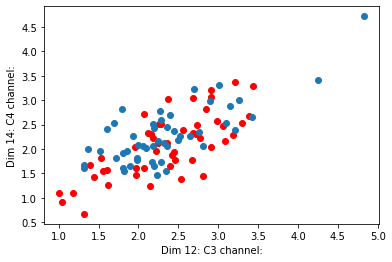

In [ ]:
tr_ft_c1 = np.log(np.var(np.array(tr_seg), 1)) [np.where(tr_Label[0,:] == 0)]
tr_ft_c2 = np.log(np.var(np.array(tr_seg), 1)) [np.where(tr_Label[0,:] == 1)]

plt.scatter(tr_ft_c1[:,ch_name.index('C3')], tr_ft_c1[:,ch_name.index('C4')], c = 'r')
plt.scatter(tr_ft_c2[:,ch_name.index('C3')], tr_ft_c2[:,ch_name.index('C4')])

plt.xlabel('Dim 12: C3 channel:')
plt.ylabel('Dim 14: C4 channel:')

## Classifier
- LDA

In [ ]:
Y = np.concatenate((np.ones(len(tr_ft_c1)), np.ones(len(tr_ft_c2))+1))
clf = LDA()
clf.fit(np.concatenate((tr_ft_c1, tr_ft_c2), axis = 0), Y)

LinearDiscriminantAnalysis()

## Performance evaluation using the test dataset
- Data processing step and parameters the should be the same 

In [ ]:
# test dataset load 
te_flt_cnt = my_filt(te_cnt_, band)

te_seg = list()
for i in range(np.size(te_Label, 1)):
    ival = range(te_marker[0, i]+interval[0], te_marker[0, i]+interval[1])
    te_seg.append(te_flt_cnt[ival, :] )
    
te_ft_c1 = np.log(np.var(np.array(te_seg), 1)) [np.where(te_Label[0,:] == 0)]
te_ft_c2 = np.log(np.var(np.array(te_seg), 1)) [np.where(te_Label[0,:] == 1)]

Yt = np.concatenate((np.ones(len(te_ft_c1)), np.ones(len(te_ft_c2))+1))
clf.predict(np.concatenate((te_ft_c1, te_ft_c2), axis = 0))
accuracy_score(Yt, clf.predict(np.concatenate((te_ft_c1, te_ft_c2), axis = 0)))

0.66

# Approach II
- Classification results with Spatial filtering - Common Spatial Filter

Here we already have segmented data:

C1: (50, 200, 62)  (trial, data points, channel)

permute -> (200, 50, 62)

reshape -> (200x50, 62) -> transpose (62, 10000) 

covariance -> (62, 62)

In [ ]:
C1 = np.array(tr_seg)[np.where(tr_Label[0,:] == 0)]
C2 = np.array(tr_seg)[np.where(tr_Label[0,:] == 1)]

C1 = np.transpose(C1, (1, 0, 2))
C2 = np.transpose(C2, (1, 0, 2))

C1 = np.reshape(C1, (10000, np.size(C1, 2)))
C2 = np.reshape(C2, (10000, np.size(C2, 2)))

Cov1 = np.cov(np.transpose(C1))
Cov2 = np.cov(np.transpose(C2))

Text(0, 0.5, 'Dim 64: CSP_64')

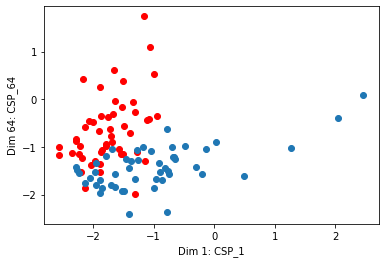

In [ ]:
from scipy.linalg import eigh

D, W = eigh(Cov1, Cov1+Cov2)
CSP_W = W[:, [0, 1, -2, -1]]

CSP_C1 = np.matmul(C1, CSP_W)
CSP_C2 = np.matmul(C2, CSP_W)

CSP_trft_c1 = np.log(np.var(np.reshape(CSP_C1, (200, 50, 4)), 0))
CSP_trft_c2 = np.log(np.var(np.reshape(CSP_C2, (200, 50, 4)), 0))
# Classificaiton

plt.scatter(CSP_trft_c1[:,0], CSP_trft_c1[:,3], c = 'r')
plt.scatter(CSP_trft_c2[:,0], CSP_trft_c2[:,3])

plt.xlabel('Dim 1: CSP_1')
plt.ylabel('Dim 64: CSP_64')

![csp2.JPG](attachment:csp2.JPG)

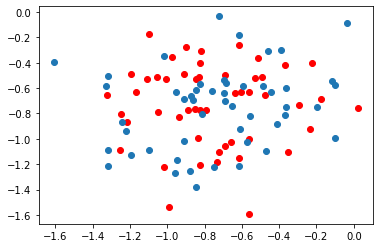

In [ ]:
CSP_W = W[:, [30, 31, 32, 33]]

CSP_C1 = np.matmul(C1, CSP_W)
CSP_C2 = np.matmul(C2, CSP_W)

CSP_trft_c1 = np.log(np.var(np.reshape(CSP_C1, (200, 50, 4)), 0))
CSP_trft_c2 = np.log(np.var(np.reshape(CSP_C2, (200, 50, 4)), 0))
# Classificaiton

plt.scatter(CSP_trft_c1[:,0], CSP_trft_c1[:,3], c = 'r')
plt.scatter(CSP_trft_c2[:,0], CSP_trft_c2[:,3])

In [ ]:
Y = np.concatenate((np.ones(len(CSP_trft_c1)), np.ones(len(CSP_trft_c2))+1))
clf = LDA()
clf.fit(np.concatenate((CSP_trft_c1, CSP_trft_c2), axis = 0), Y)

LinearDiscriminantAnalysis()

If we use the general parameters, then we do not need a validation dataset. 
- 8-12 band for all the subject. 
However, if we want to find user-specific frecuenty bands, then we have to create a validataion dataset
- 9-15 for subject 1, 5-20 for subject 2 ...
- Training dataset can be divided into training / validation with the specific ratio (50/50). 
- Cross-validation based on the training dataset

In [ ]:
te_flt_cnt = my_filt(te_cnt_, band)

te_seg = list()
for i in range(np.size(te_Label, 1)):
    ival = range(te_marker[0, i]+interval[0], te_marker[0, i]+interval[1])
    te_seg.append(te_flt_cnt[ival, :] )

    
C1 = np.array(tr_seg)[np.where(tr_Label[0,:] == 0)]
C2 = np.array(tr_seg)[np.where(tr_Label[0,:] == 1)]

C1 = np.transpose(C1, (1, 0, 2))
C2 = np.transpose(C2, (1, 0, 2))
C1 = np.reshape(C1, (10000, np.size(C1, 2)))
C2 = np.reshape(C2, (10000, np.size(C2, 2)))
    
CSP_C1 = np.matmul(C1, CSP_W)
CSP_C2 = np.matmul(C2, CSP_W)

CSP_teft_c1 = np.log(np.var(np.reshape(CSP_C1, (200, 50, 4)), 0))
CSP_teft_c2 = np.log(np.var(np.reshape(CSP_C2, (200, 50, 4)), 0))
 
Yt = np.concatenate((np.ones(len(CSP_teft_c1)), np.ones(len(CSP_teft_c2))+1))
clf.predict(np.concatenate((CSP_teft_c1, CSP_teft_c2), axis = 0))
accuracy_score(Yt, clf.predict(np.concatenate((CSP_teft_c1, CSP_teft_c2), axis = 0)))

0.49

## Homework
- Here we want to find user specific frequency bands

1) Define possible frequency bands ( > 5)

2) Investigate the performances according to the frequency bands within the training data

3) Find one best frequency band and apply it to the test dataset. 

In [ ]:
def mi_pipe(dat, label, band = [8, 12], ival=[75, 350] , ch = [], csp = [0, 1, -2, -1]):
    sos = butter(5, band, 'band', fs=100, output='sos')   
    fdat = list()
    for i in range(np.size(dat, 1)):
        tm = signal.sosfilt(sos, dat[:,i])
        fdat.append(tm)  
        
    tr_seg = list()
    for i in range(np.size(tr_Label, 1)):
        ival = range(tr_marker[0, i]+interval[0], tr_marker[0, i]+interval[1])
        tr_seg.append(tr_flt_cnt[ival, :] ) 

    
    
    